# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
% matplotlib inline

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv');
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
import requests
import os

response = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")

if response.status_code == 200:
    # Save the file
    with open("image_predictions.tsv", "wb") as file:
        file.write(response.content)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [3]:
!pip install tweepy

I got issue because I dont have charge account. So I will get the file json in your resources.

In [4]:
import json

tweet_json_df = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet-json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        tweet_json_df = tweet_json_df .append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],columns=['tweet_id', 'retweet_count', 'favorite_count']))
tweet_json_df = tweet_json_df.reset_index(drop=True)
tweet_json_df.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [5]:
twitter = pd.read_csv('image_predictions.tsv', sep = '\t')
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [6]:
twitter.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### Quality issues
1. Inaccurate Data Types: The 'timestamp' column should be converted to datetime format, and 'tweet_id' should be represented as a string.

2. Nonstandard Name Capitalization: The 'name' column exhibits inconsistent capitalization, including lowercase or 'None' entries, necessitating normalization.

3. Presence of Multiple Dog Stages: Some tweets indicate multiple dog stages (e.g., doggo, floofer, pupper, puppo), demanding clarification for accurate interpretation.

4. Data Containing Retweets: Rows containing retweet data need to be removed for accurate analysis.

5. Missing Values in Essential Columns: Several columns, including 'in_reply_to_status_id,' 'in_reply_to_user_id,' 'retweeted_status_id,' 'retweeted_status_user_id,' 'retweeted_status_timestamp,' and 'expanded_urls,' have missing values that need to be addressed.

6. Unnecessary URLs in Text: Extraneous URLs within the 'text' column should be removed, streamlining the data for analysis.

7. Questionable Rating Numerators and Denominators: Instances of potentially incorrect or inconsistent 'rating_numerator' and 'rating_denominator' values 

8. Incoherent Source Presentation: The 'source' column contains both HTML tags and extraneous information, which requires formatting for consistency.

### Tidiness issues
1. Data Integration: Collate the data dispersed across multiple tables into a cohesive master pandas DataFrame, facilitating streamlined analysis.

2. Dog Stages Consolidation: The 'doggo,' 'floofer,' 'pupper,' and 'puppo' columns can be merged into a unified column named 'dog_stage.'

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [7]:
# Make copies of original pieces of data
twitter_clean = twitter.copy()
enhanced_clean = twitter_archive.copy()
tweet_json_df_clean = tweet_json_df.copy()

### Issue #1.1:

#### Define: Exclude all entries that contain retweets.

#### Code

In [8]:
enhanced_clean = enhanced_clean[enhanced_clean.retweeted_status_id.isnull()]

#### Test

In [9]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Issue #1.2:

#### Define: Replace the missing values in each column with a suitable value.

#### Code

In [10]:
[
    "in_reply_to_status_id",
    "in_reply_to_user_id",
    "retweeted_status_id",
    "retweeted_status_user_id",
    "retweeted_status_timestamp",
    "expanded_urls"
]
enhanced_clean['in_reply_to_status_id'].fillna(0, inplace=True)
enhanced_clean['in_reply_to_user_id'].fillna(0, inplace=True)
enhanced_clean['retweeted_status_id'].fillna(0, inplace=True)
enhanced_clean['retweeted_status_user_id'].fillna(0, inplace=True)
enhanced_clean['retweeted_status_timestamp'].fillna(0, inplace=True)
enhanced_clean['expanded_urls'].fillna("", inplace=True)

#### Test

In [11]:
enhanced_clean.isnull().sum()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

### Issue #1.3:

#### Define: Convert the data type of this column to the appropriate type.

#### Code

In [12]:
enhanced_clean['timestamp'] = pd.to_datetime(enhanced_clean['timestamp'])
enhanced_clean['tweet_id'] = enhanced_clean['tweet_id'].astype(str)
enhanced_clean['in_reply_to_status_id'] = enhanced_clean['in_reply_to_status_id'].astype(str)
enhanced_clean['in_reply_to_user_id'] = enhanced_clean['in_reply_to_user_id'].astype(str)

#### Test

In [13]:
enhanced_clean['timestamp'].dtype

dtype('<M8[ns]')

### Issue #1.4:

#### Define: Introduce a new column to accurately represent the rating.

#### Code

In [14]:
enhanced_clean['rating'] = enhanced_clean['text'].str.extract(r'(\d+(\.\d+)?\/\d+)')[0]

enhanced_clean['rating_numerator'], enhanced_clean['rating_denominator'] = enhanced_clean['rating'].str.split('/', 1).str

enhanced_clean['rating_numerator'] = enhanced_clean['rating_numerator'].astype(float)
enhanced_clean['rating_denominator'] = enhanced_clean['rating_denominator'].astype(float)

#### Test

In [15]:
enhanced_clean.rating.head()

0    13/10
1    13/10
2    12/10
3    13/10
4    12/10
Name: rating, dtype: object

### Issue #1.5:

#### Define: Update all lowercase names to "None".

#### Code

In [16]:
enhanced_clean['name'] = enhanced_clean['name'].replace(r'^[a-z]+$', 'None', regex=True)

#### Test

In [17]:
enhanced_clean.loc[enhanced_clean['name'].str.islower(), 'name']

Series([], Name: name, dtype: object)

### Issue #1.6:

#### Define:  Eliminate any HTML syntax present in the text.

#### Code

In [18]:
enhanced_clean['source'] = enhanced_clean['source'].str.replace(r'<[^>]+>', '', regex=True)

#### Test

In [19]:
enhanced_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Issue #1.7:

#### Define: Remove any URLs from the text.

#### Code

In [20]:
enhanced_clean['text'] = enhanced_clean['text'].str.replace(r'http\S+|www.\S+', '', regex=True)

#### Test

In [21]:
enhanced_clean['text'].head()

0    This is Phineas. He's a mystical boy. Only eve...
1    This is Tilly. She's just checking pup on you....
2    This is Archie. He is a rare Norwegian Pouncin...
3    This is Darla. She commenced a snooze mid meal...
4    This is Franklin. He would like you to stop ca...
Name: text, dtype: object

### Issue #1.8:

#### Define: Convert the data type of the timestamp column to a time format.

#### Code

In [22]:
enhanced_clean['timestamp'] = pd.to_datetime(enhanced_clean['timestamp'])

#### Test

In [23]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null float64
retweeted_status_user_id      2175 non-null float64
retweeted_status_timestamp    2175 non-null int64
expanded_urls                 2175 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
rating         

### Issue #2.1:

#### Define: Remove the columns for doggo, floofer, pupper, and puppo, and create a new combined column.

#### Code

In [24]:
enhanced_clean.doggo.replace('None', '', inplace=True)
enhanced_clean.floofer.replace('None', '', inplace=True)
enhanced_clean.pupper.replace('None', '', inplace=True)
enhanced_clean.puppo.replace('None', '', inplace=True)


In [25]:
enhanced_clean['dog_stage'] = ''
enhanced_clean['dog_stage'] = enhanced_clean['doggo'] + enhanced_clean['floofer'] + enhanced_clean['pupper'] +enhanced_clean['puppo']
enhanced_clean['dog_stage'] = enhanced_clean['dog_stage'].str.strip(',')
enhanced_clean = enhanced_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

enhanced_clean.loc[enhanced_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper' 
enhanced_clean.loc[enhanced_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo' 
enhanced_clean.loc[enhanced_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

#### Test

In [26]:
enhanced_clean['dog_stage'].value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

### Issue #2.2:

#### Define: Combine the different datasets into one cohesive dataset.

#### Code

In [27]:
twitter_clean['tweet_id'] = twitter_clean['tweet_id'].astype(str)

merged_df_clean = pd.merge(twitter_clean, tweet_json_df_clean, on='tweet_id')
merged_df_clean = pd.merge(enhanced_clean, merged_df_clean, on='tweet_id')

#### Test

In [28]:
merged_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           1994 non-null float64
retweeted_status_user_id      1994 non-null float64
retweeted_status_timestamp    1994 non-null int64
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null float64
rating_denominator            1994 non-null float64
name                          1994 non-null object
rating                        1994 non-null object
dog_stage                     1994 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null int64
p1              

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [29]:
master_df = enhanced_clean
master_df.to_csv('twitter_archive_master.csv', index=False)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null float64
retweeted_status_user_id      2175 non-null float64
retweeted_status_timestamp    2175 non-null int64
expanded_urls                 2175 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
rating                        2175 non-null object
dog_stage                     2175 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(9)
memory usage: 271.9+ KB


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

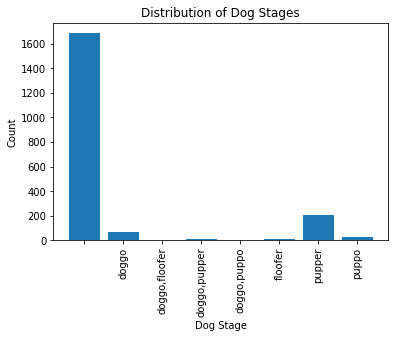

In [30]:
dog_stage_counts = merged_df_clean['dog_stage'].value_counts()


plt.bar(dog_stage_counts.index, dog_stage_counts.values)
plt.xticks(rotation='vertical')
plt.xlabel('Dog Stage')
plt.ylabel('Count')
plt.title('Distribution of Dog Stages')
plt.show()

### Insights:
1.Popular Dog Breeds

2.Dog Stage Distribution

3.Rating Distribution

### Visualization

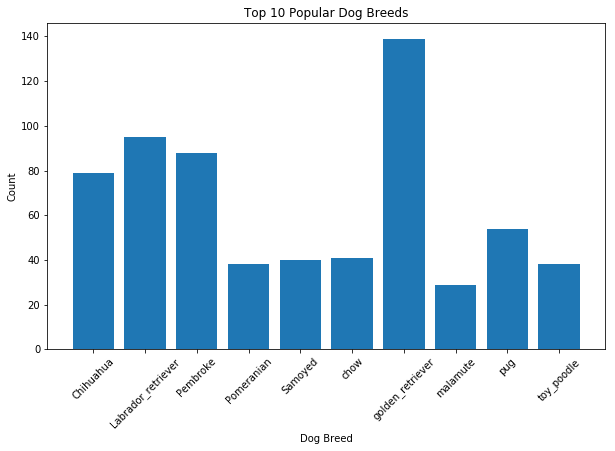

In [31]:
dog_breed_counts = merged_df_clean['p1'].value_counts().head(10)

# Create a bar bchart
plt.figure(figsize=(10, 6))
plt.bar(dog_breed_counts.index, dog_breed_counts.values)
plt.xlabel('Dog Breed')
plt.ylabel('Count')
plt.title('Top 10 Popular Dog Breeds')
plt.xticks(rotation=45)
plt.show()

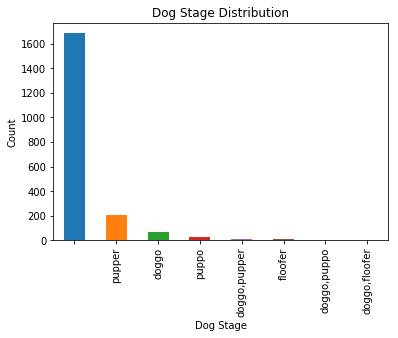

In [32]:
stage_counts = merged_df_clean['dog_stage'].value_counts()
stage_counts.plot(kind='bar')
plt.title('Dog Stage Distribution')
plt.xlabel('Dog Stage')
plt.ylabel('Count')
plt.show()

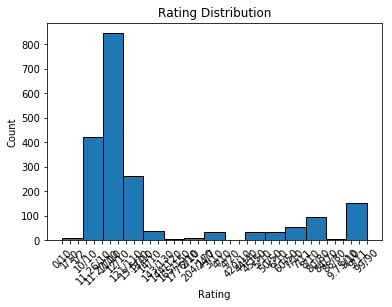

In [33]:
plt.hist(merged_df_clean['rating'], bins=15, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.xticks(rotation=90)
plt.show()